## Importing Libraries

In [ ]:
!python -m pip install transformers
!python -m pip install Sastrawi
!python -m pip install xformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 7.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from Sastrawi.Dictionary.ArrayDictionary import ArrayDictionary
from Sastrawi.StopWordRemover.StopWordRemover import StopWordRemover
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

plt.style.use('ggplot')
np.__version__

'1.22.4'

## Loading the data

In [ ]:
!gdown 1EgJ4xUZeNzzCMjRe4Y5c1rTsmhWLD8lL
!gdown 1SRnkEDcMsfFao7YmxRAP6z246QjKpFiS

Downloading...
From: https://drive.google.com/uc?id=1EgJ4xUZeNzzCMjRe4Y5c1rTsmhWLD8lL
To: /content/Symptom2DiseaseID.csv
100% 240k/240k [00:00<00:00, 89.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SRnkEDcMsfFao7YmxRAP6z246QjKpFiS
To: /content/Converted DS Dataset-revised.csv
100% 3.84M/3.84M [00:00<00:00, 220MB/s]


In [ ]:
dfNLP = pd.read_csv('./Symptom2DiseaseID.csv', delimiter=';')
dfNLP.drop("indeks", axis=1, inplace=True)
dfNLP.head()

,label,text
0,Psoriasis,"Saya telah mengalami ruam kulit di lengan, ka..."
1,Psoriasis,"Kulit saya mengelupas, terutama di lutut, sik..."
2,Psoriasis,"Saya telah mengalami nyeri sendi di jari, per..."
3,Psoriasis,"Ada debu seperti perak di kulit saya, terutam..."
4,Psoriasis,Kuku saya memiliki penyok atau lubang kecil d...


In [ ]:
dfCnv = pd.read_csv('./Converted DS Dataset-revised.csv', delimiter=';')
dfCnv.head()

,gejala,prognosa
0,Saya tidak merasakan penambahan berat badan. S...,0
1,Saya mengalami patch diskromik dalam beberapa ...,0
2,Saya tidak merasakan batuk. Sering bermasalah ...,0
3,"Sesekali, ruam kulit saya rasakan. Tidak ada k...",0
4,Saya tidak merasakan adanya demam ringan. Saya...,0


In [ ]:
dfNLP['label'] = dfNLP['label'].replace({' Pembuluh mekar':'Varises', ' Wasir Dimorfik' : 'Wasir', ' spondylosis serviks':'Spondylosis'})
dfCnv.rename(columns={'gejala': 'text', 'prognosa': 'label'}, inplace=True)
dfCnv = dfCnv[dfCnv.columns[::-1]]

In [ ]:
indextolabel = {
    0: 'Vertigo Posisi Paroymsal',
    1: 'AIDS',
    2: 'Alergi',
    3: 'Asma bronkial',
    4: 'Cacar air',
    5: 'Diabetes',
    6: 'Flu biasa',
    7: 'GERD',
    8: 'Gastroenteritis',
    9: 'Hepatitis B',
    10: 'Hepatitis C',
    11: 'Hepatitis D',
    12: 'Hepatitis E',
    13: 'Hepatitis alkoholik',
    14: 'Hipertensi',
    15: 'Hipertiroidisme',
    16: 'Hipoglikemia',
    17: 'Hipotiroidisme',
    18: 'Impetigo',
    19: 'Infeksi jamur',
    20: 'Infeksi saluran kemih',
    21: 'Jerawat',
    22: 'Pendarahan Otak',
    23: 'Malaria',
    24: 'Migrain',
    25: 'Osteoartritis',
    26: 'Varises',
    27: 'Penyakit kuning',
    28: 'Penyakit tipus',
    29: 'Penyakit ulkus peptikum',
    30: 'Psoriasis',
    31: 'Radang paru-paru',
    32: 'Radang sendi',
    33: 'Reaksi Obat',
    34: 'Serangan jantung',
    35: 'TBC',
    36: 'Wasir',
    37: 'demam berdarah',
    38: 'hepatitis A',
    39: 'kolestasis kronis',
    40: 'Spondylosis',
}

dfCnv['label'] = dfCnv['label'].replace(indextolabel)

In [ ]:
dfNLP['label'].value_counts()

 Psoriasis                          50
Varises                             50
 penyakit ulkus peptikum            50
 reaksi obat                        50
 penyakit refluks gastroesofagus    50
 alergi                             50
 Infeksi saluran kemih              50
 Malaria                            50
 Penyakit kuning                    50
Spondylosis                         50
 Migrain                            50
 Hipertensi                         50
 Asma bronkial                      50
 Jerawat                            50
 Radang sendi                       50
Wasir                               50
 Radang paru-paru                   50
 Flu biasa                          50
 Infeksi jamur                      50
 demam berdarah                     50
 Impetigo                           50
 Cacar air                          50
 Penyakit tipus                     50
 diabetes                           50
Name: label, dtype: int64

In [ ]:
dfCnv['label'].value_counts()

Vertigo Posisi Paroymsal    240
Jerawat                     240
Malaria                     240
Migrain                     240
Osteoartritis               240
Varises                     240
Penyakit kuning             240
Penyakit tipus              240
Penyakit ulkus peptikum     240
Psoriasis                   240
Radang paru-paru            240
Radang sendi                240
Reaksi Obat                 240
Serangan jantung            240
TBC                         240
Wasir                       240
demam berdarah              240
hepatitis A                 240
kolestasis kronis           240
Pendarahan Otak             240
Infeksi saluran kemih       240
AIDS                        240
Infeksi jamur               240
Alergi                      240
Asma bronkial               240
Cacar air                   240
Diabetes                    240
Flu biasa                   240
GERD                        240
Gastroenteritis             240
Hepatitis B                 240
Hepatiti

In [ ]:
dfMerge = pd.concat([dfCnv, dfNLP], ignore_index=True)

In [ ]:
dfMerge.head()

,label,text
0,Vertigo Posisi Paroymsal,Saya tidak merasakan penambahan berat badan. S...
1,Vertigo Posisi Paroymsal,Saya mengalami patch diskromik dalam beberapa ...
2,Vertigo Posisi Paroymsal,Saya tidak merasakan batuk. Sering bermasalah ...
3,Vertigo Posisi Paroymsal,"Sesekali, ruam kulit saya rasakan. Tidak ada k..."
4,Vertigo Posisi Paroymsal,Saya tidak merasakan adanya demam ringan. Saya...


In [ ]:
import itertools
factory = StopWordRemoverFactory()

addStopwords = ['dengan', 'ia', 'bahwa', 'oleh', 'saya']
removeStopwords = ['namun', 'tidak', 'setelah', 'masih', 'dengan', "merasakan", "adanya", "ada"]

stopWords = factory.get_stop_words()+addStopwords

for removeStopword in removeStopwords:
    if removeStopword in stopWords:
        stopWords.remove(removeStopword)
    else:
        continue

dictionaryWord = ArrayDictionary(stopWords)
stopWordRemover = StopWordRemover(dictionaryWord)

dfMerge["text"] = dfMerge["text"].str.lstrip()

for i in range(len(dfMerge["text"])):
    dfMerge["text"][i] = re.sub('  +', ' ', dfMerge["text"][i])
    dfMerge["text"][i] = re.sub(r'[^\x00-\x7f]','r', dfMerge["text"][i])
    dfMerge["text"][i] = dfMerge["text"][i].encode('ascii', 'ignore').decode('utf-8')
    dfMerge["text"][i] = ''.join(''.join(s)[:1] for _, s in itertools.groupby(dfMerge["text"][i]))
    dfMerge["text"][i] = dfMerge["text"][i].lower()
    dfMerge["text"][i] = stopWordRemover.remove(dfMerge["text"][i])
    dfMerge["label"][i] = dfMerge["label"][i].lower()
    dfMerge["label"][i] = dfMerge["label"][i].title()

dfMerge.label = dfMerge.label.str.replace('^ +| +$', '', regex=True)

In [ ]:
dfMerge = dfMerge.drop(dfMerge[dfMerge['label'] == 'Penyakit Refluks Gastroesofagus'].index)

In [ ]:
dfMerge.head()

,label,text
0,Vertigo Posisi Paroymsal,tidak merasakan penambahan berat badan. mengal...
1,Vertigo Posisi Paroymsal,mengalami patch diskromik beberapa hari terakh...
2,Vertigo Posisi Paroymsal,tidak merasakan batuk. sering bermasalah gatal...
3,Vertigo Posisi Paroymsal,"sesekali, ruam kulit rasakan. tidak ada keasam..."
4,Vertigo Posisi Paroymsal,tidak merasakan adanya demam ringan. tidak mer...


In [ ]:
# df_sampel = pd.concat([dfMerge[dfMerge['label'] == kelas].sample(n=50, random_state=42) for kelas in dfMerge['label'].unique() if kelas not in ['Pembuluh Mekar', 'Wasir Dimorfik', 'Penyakit Refluks Gastroesofagus']])
# dfMerge = pd.concat([dfMerge[dfMerge['label'].isin(['Pembuluh Mekar', 'Wasir Dimorfik', 'Penyakit Refluks Gastroesofagus'])], df_sampel])

In [ ]:
for nama_kolom in dfMerge.columns:
  print(dfMerge[nama_kolom].value_counts(), "\n")

Infeksi Saluran Kemih       290
Impetigo                    290
Demam Berdarah              290
Wasir                       290
Reaksi Obat                 290
Radang Sendi                290
Radang Paru-Paru            290
Psoriasis                   290
Penyakit Ulkus Peptikum     290
Penyakit Tipus              290
Penyakit Kuning             290
Varises                     290
Migrain                     290
Malaria                     290
Jerawat                     290
Infeksi Jamur               290
Spondylosis                 290
Hipertensi                  290
Alergi                      290
Asma Bronkial               290
Cacar Air                   290
Diabetes                    290
Flu Biasa                   290
Hipotiroidisme              240
Gerd                        240
Kolestasis Kronis           240
Hepatitis A                 240
Tbc                         240
Serangan Jantung            240
Gastroenteritis             240
Hipoglikemia                240
Hepatiti

Creating encodings for disease.

In [ ]:
int2label = {}

for i, disease in enumerate(dfMerge['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

int2label, label2int

({0: 'Vertigo Posisi Paroymsal',
  1: 'Aids',
  2: 'Alergi',
  3: 'Asma Bronkial',
  4: 'Cacar Air',
  5: 'Diabetes',
  6: 'Flu Biasa',
  7: 'Gerd',
  8: 'Gastroenteritis',
  9: 'Hepatitis B',
  10: 'Hepatitis C',
  11: 'Hepatitis D',
  12: 'Hepatitis E',
  13: 'Hepatitis Alkoholik',
  14: 'Hipertensi',
  15: 'Hipertiroidisme',
  16: 'Hipoglikemia',
  17: 'Hipotiroidisme',
  18: 'Impetigo',
  19: 'Infeksi Jamur',
  20: 'Infeksi Saluran Kemih',
  21: 'Jerawat',
  22: 'Pendarahan Otak',
  23: 'Malaria',
  24: 'Migrain',
  25: 'Osteoartritis',
  26: 'Varises',
  27: 'Penyakit Kuning',
  28: 'Penyakit Tipus',
  29: 'Penyakit Ulkus Peptikum',
  30: 'Psoriasis',
  31: 'Radang Paru-Paru',
  32: 'Radang Sendi',
  33: 'Reaksi Obat',
  34: 'Serangan Jantung',
  35: 'Tbc',
  36: 'Wasir',
  37: 'Demam Berdarah',
  38: 'Hepatitis A',
  39: 'Kolestasis Kronis',
  40: 'Spondylosis'},
 {'Vertigo Posisi Paroymsal': 0,
  'Aids': 1,
  'Alergi': 2,
  'Asma Bronkial': 3,
  'Cacar Air': 4,
  'Diabetes': 5,


## Data Distribution

Text(0.5, 1.0, 'Jumlah Data untuk masing-masing penyakit')

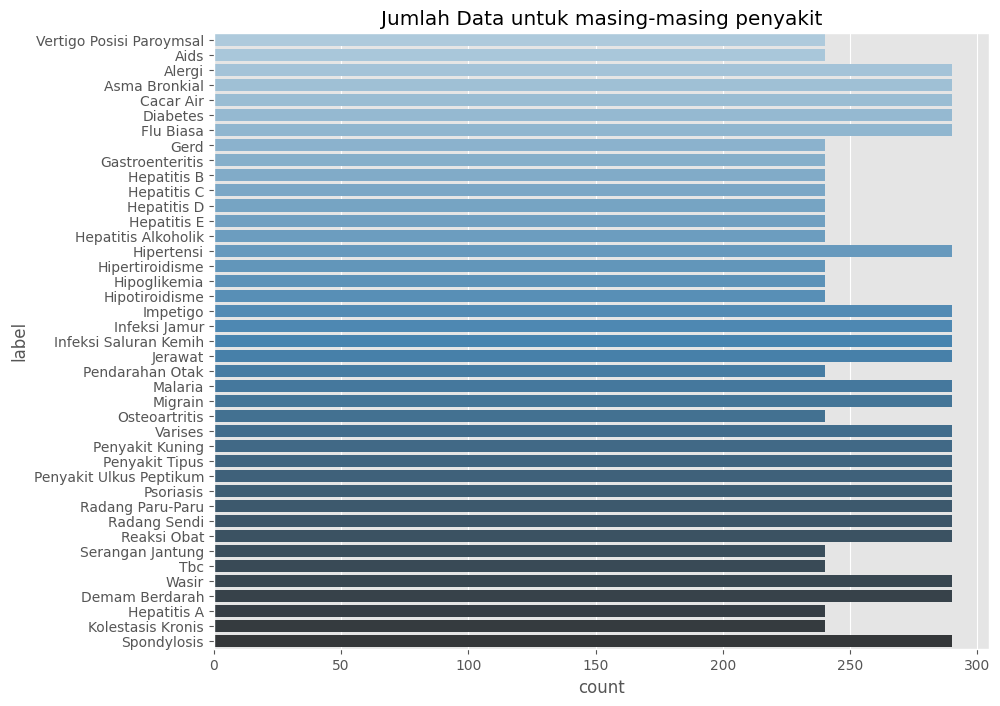

In [ ]:
plt.figure(figsize = (10, 8))

sea.countplot(y = dfMerge['label'], palette = 'Blues_d')
plt.title('Jumlah Data untuk masing-masing penyakit')

## Distribution of the lenght of description

  0%|          | 0/10990 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of description length')

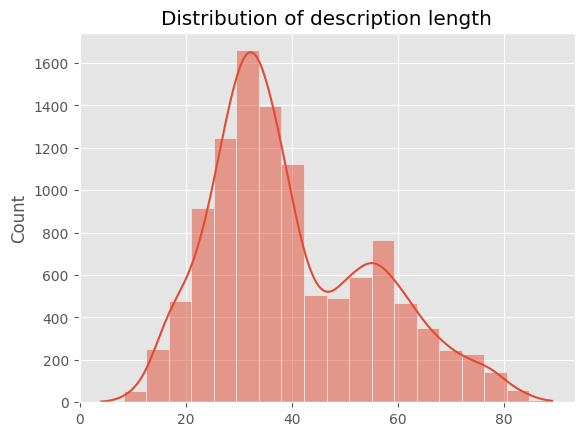

In [ ]:
# Masih perlu disesuaikan distribusi datanya, jangan ada yang kepanjangan

length = []
for txt in tqdm(dfMerge['text'].values):
    length.append(len(txt.split()))

sea.histplot(length, kde = True, bins = 20)
plt.title('Distribution of description length')

In [ ]:
dfMerge['label'] = dfMerge['label'].map(lambda x : label2int[x])

In [ ]:
X, y = dfMerge['text'].values, dfMerge['label'].values

x_tokenizer = Tokenizer(filters = '')
x_tokenizer.fit_on_texts(X)
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

X vocab: 1795


## Creating the train and testing data

In [ ]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((9891,), (1099,), (9891,), (1099,))

In [ ]:
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
train_encodings = tokenizer(list(train_x), padding="max_length", truncation=True)
val_encodings = tokenizer(list(val_x), padding="max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)


In [ ]:
num_classes = 41

from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    num_labels = num_classes, 
    id2label = int2label, 
    label2id = label2int,
    output_attentions = True)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['accuracy'])

model

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7f739e733490> True
<keras.layers.regularization.dropout.Dropout object at 0x7f739e4d9870> True
<keras.layers.core.dense.Dense object at 0x7f739e4d9c60> True


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  31529     
                                                                 
Total params: 177,884,969
Trainable params: 177,884,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 10
batch_size = 32

history = model.fit(train_dataset,
          batch_size=batch_size,
          epochs = EPOCHS,
          validation_data = val_dataset)

Epoch 1/10
1237/1237 [==============================] - 1262s 976ms/step - loss: 1.4452 - accuracy: 0.6807 - val_loss: 0.1830 - val_accuracy: 0.9627
Epoch 2/10
1237/1237 [==============================] - 1249s 1s/step - loss: 0.1234 - accuracy: 0.9795 - val_loss: 0.0543 - val_accuracy: 0.9909
Epoch 3/10
1237/1237 [==============================] - 1247s 1s/step - loss: 0.0617 - accuracy: 0.9874 - val_loss: 0.0511 - val_accuracy: 0.9864
Epoch 4/10
1237/1237 [==============================] - 1247s 1s/step - loss: 0.0249 - accuracy: 0.9949 - val_loss: 0.0694 - val_accuracy: 0.9791
Epoch 5/10
1237/1237 [==============================] - 1211s 979ms/step - loss: 0.0278 - accuracy: 0.9929 - val_loss: 0.0446 - val_accuracy: 0.9891
Epoch 6/10
1237/1237 [==============================] - 1212s 980ms/step - loss: 0.0327 - accuracy: 0.9916 - val_loss: 0.0307 - val_accuracy: 0.9909
Epoch 7/10
1237/1237 [==============================] - 1212s 980ms/step - loss: 0.0093 - accuracy: 0.9984 - val_lo

In [ ]:
model.evaluate(val_dataset, batch_size=batch_size)

138/138 [==============================] - 47s 338ms/step - loss: 0.0521 - accuracy: 0.9882


[0.0520809032022953, 0.9881710410118103]

## Plotting the loss and accuracy plot.

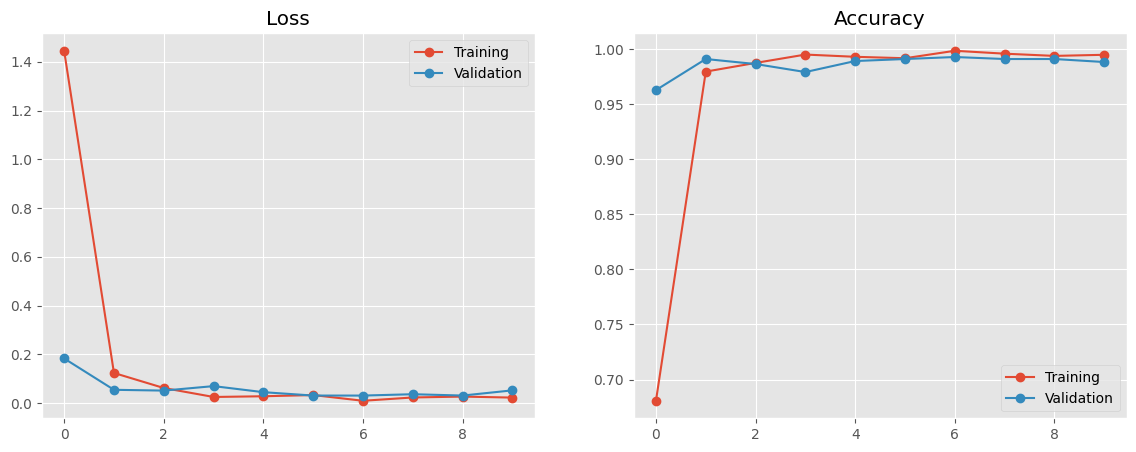

In [ ]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()

## Testing the model on custom input.

In [ ]:
path = "./model_merge_bert_multilungual_v3"
path2 = "./tokenizer_merge_bert_multilungual_v3"
model.save_pretrained(path)
tokenizer.save_pretrained(path2)

('./tokenizer_merge_bert_multilungual_v3/tokenizer_config.json',
 './tokenizer_merge_bert_multilungual_v3/special_tokens_map.json',
 './tokenizer_merge_bert_multilungual_v3/vocab.txt',
 './tokenizer_merge_bert_multilungual_v3/added_tokens.json',
 './tokenizer_merge_bert_multilungual_v3/tokenizer.json')

In [ ]:
!zip -r model_merge_bert_multilungual_v3.zip "/content/model_merge_bert_multilungual_v3"

  adding: content/model_merge_bert_multilungual_v3/ (stored 0%)
  adding: content/model_merge_bert_multilungual_v3/config.json (deflated 62%)
  adding: content/model_merge_bert_multilungual_v3/tf_model.h5 (deflated 7%)


In [ ]:
!zip -r tokenizer_merge_bert_multilungual_v3.zip "/content/tokenizer_merge_bert_multilungual_v3"

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, BertModel

In [ ]:
tokenizerlocal = BertTokenizer.from_pretrained("./tokenizer_merge_bert_multilungual_v3", local_files_only=True)

In [ ]:
modellocal = BertForSequenceClassification.from_pretrained("./model_merge_bert_multilungual_v3", from_tf=True)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=modellocal, tokenizer=tokenizerlocal, top_k = 24)

text1 = str(" Penglihatan saya berkabut, dan tampaknya semakin memburuk. Saya merasa lelah dan lelah sepanjang waktu. Saya juga sering mengalami pusing parah dan pusing.").lower()
text2 = str("Saya mengalami sembelit dan sakit perut, dan itu sangat tidak nyaman. Sakit perut semakin parah dan mulai mempengaruhi kehidupan sehari-hari saya. Apalagi setiap malam saya menggigil, diikuti demam ringan.").lower()
text3 = str(" saya merasa sangat gatal, sakit, dan lelah. selain itu, berat badan saya turun dan suhu tubuh saya naik. urine saya berwarna gelap, dan kulit saya menjadi kuning. selain itu, saya juga mengalami sakit perut.").lower()

pred1 = pipe(text1)
pred2 = pipe(text2)
pred3 = pipe(text3)

print(pred1[0][:2])
print(pred2[0][:2])
print(pred3[0][:2])

[{'label': 'Diabetes', 'score': 0.991198718547821}, {'label': 'Migrain', 'score': 0.007056170608848333}]
[{'label': 'Penyakit Tipus', 'score': 0.99915611743927}, {'label': 'Demam Berdarah', 'score': 9.729956946102902e-05}]
[{'label': 'Penyakit Kuning', 'score': 0.9996534585952759}, {'label': 'Hipertensi', 'score': 4.084131433046423e-05}]


In [ ]:
!ls -lh tokenizer_merge_bert_multilungual_v3.zip model_merge_bert_multilungual_v3.zip

-rw-r--r-- 1 root root 630M Jun  3 22:25 model_merge_bert_multilungual_v3.zip
-rw-r--r-- 1 root root 1.5M Jun  3 22:25 tokenizer_merge_bert_multilungual_v3.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r model_merge_bert_multilungual_v3.zip "/content/drive/My Drive/Save Model Capstone/"

In [ ]:
!cp -r tokenizer_merge_bert_multilungual_v3.zip "/content/drive/My Drive/Save Model Capstone/"

In [ ]:
dfMerge.to_csv('data_merge_nlp-csv_clean_v3.csv', index = False, header = True, index_label = None)
!cp -r data_merge_nlp-csv_clean_v3.csv "/content/drive/My Drive/Save Model Capstone/"